# Full Paper Replication & Spectral Clustering with Cryptocurrencies

In this notebook I replicate the paper's results but with cryptocurrencies and instead of using only a single base currency (as in previous notebooks) we use all of the currencies as base currencies throughout the notebook. This allows us to look at time series of the max eigenvalues and do comparisons of "importances" of different cryptocurrencies in the market.

The data we use here is the hourly data.

## Contents
- [Read & Clean Data](#first-bullet)
- [Base Currency Transform Function](#second-bullet)
- [Correlation Matrix](#second-bullet)
- [Eigenspectra](#third-bullet)
- [Cluster Structure](#fourth-bullet)
    - Threshold method (paper uses)
    - Spectral clustering (we use)
- [Minimal Spanning Trees (for visualizing)](#fifth-bullet)

### Read & Clean Data

Note that column names are xxxyyy where xxx is the numerator currency and yyy is the base. Some currencies have four letter names as well.

In [4]:
import pandas as pd
import numpy as np
import sklearn as sk
import random
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from sklearn.cluster import SpectralClustering
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import squareform
from mjc import MJC
from itertools import product
import statsmodels.api as sm

exch_dat = pd.read_csv('../data/Poloniex_All_BTC_Clean.csv')
exch_dat = exch_dat.iloc[:, 1:]  # remove row num column
exch_dat.index = exch_dat['Date']  # sets Date col as index
exch_dat = exch_dat.drop(['Date'], axis=1)  # removes it
exch_dat.columns = ['BCHBTC','DASHBTC','ETCBTC','ETHBTC','GASBTC','GNOBTC',
                   'LSKBTC','LTCBTC','NXTBTC','OMGBTC','POTBTC','REPBTC','XEMBTC',
                   'XMRBTC','XRPBTC','ZECBTC','ZRXBTC','USDBTC']  # cleans col names
all_currs = [x.replace('BTC','') for x in 
             list(exch_dat.columns)] + ['BTC']  # all the currencies in the data

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Base Currency Transform Function
This is used to transform data from x/y where y is the base to x/z where z is the new base.

In [6]:
def trans_base(data, curr_base, new_base):
    dat = data.copy()
    # Function: x/curr_base --> x/new_base
    #
    # The base variables should be strings 
    # such as 'BTC', 'USD', or 'ETH'.
    # The function is not as careful with
    # user inputs as it should be but I 
    # don't expect it to be used by random
    # people so it doesn't need to be robust
    # to user errors.
    #
    # Output --> New data frame with changed
    # column names as well as new data.
    
    inv = 1 / dat[new_base+curr_base]  # this column just needs to be inversed 1/x
    
    # Input Checking
    names = [x.replace(curr_base,'') for x in list(dat.columns)]  # removes base from names
    if new_base not in names:  # is the new base in our data?
        raise ValueError('New base not in data!')
    if any([curr_base not in x for x in list(dat.columns)]):  # is the user given base correct?
        raise ValueError('What you say is the base is wrong!')
    
    # Compute Multiplications
    loc = names.index(new_base)  # location of inverse multiplier in data
    for jc in dat.columns:  # x/y * y/z = x/z
        dat[jc] = dat[jc] * (1 / dat.iloc[:,loc])
    
    # Re-Do Column names
    new_names = [x + new_base for x in names]  # puts new base into name
    dat.columns = new_names
    dat[new_base+new_base] = inv  # replace 1's col with inverse col
    new_names[new_names.index(new_base+new_base)] = curr_base+new_base
    dat.columns = new_names
    
    return dat

### Correlation Matrix of Log Returns

Using BTC as base for ease but can easily be transformed using the above.

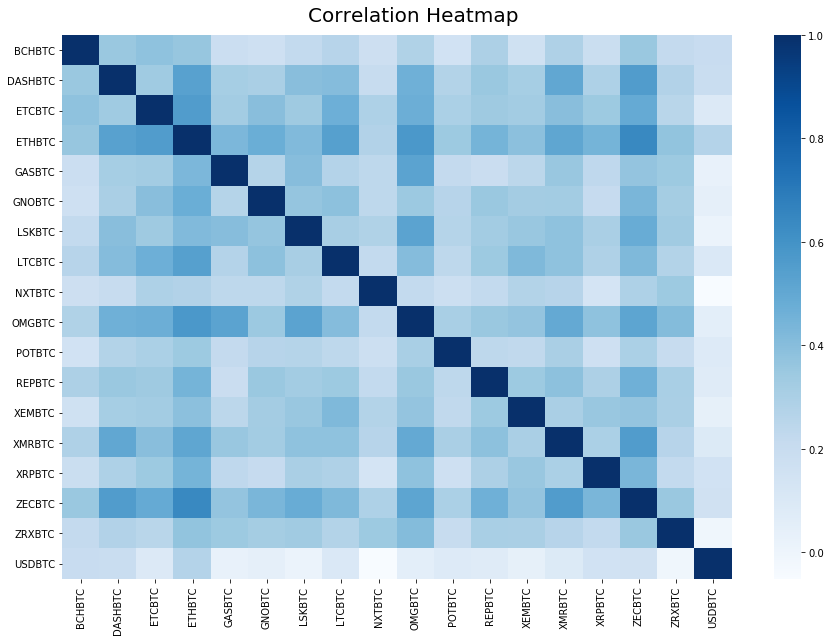

In [7]:
exch_logrets = np.log(exch_dat) - np.log(exch_dat.shift(1))
exch_logrets = exch_logrets.iloc[1:,:]
C = exch_logrets.corr() 

#Heatmap of Corr
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Correlation Heatmap", fontsize=20, x=.45, y=.92)
sns.heatmap(C, cmap="Blues", xticklabels=C.columns, yticklabels=C.columns);
plt.show();

### EigenSpectra Compared for all Base Currencies

This is intended to replicate (convey the same information) as _Figure 1_ in the Kwapień paper. It compares the eigen values for a number of different base currencies. 

In [178]:
eigs_mtx = np.zeros((len(all_currs), len(all_currs)-1))  # bin to hold all eig values

# Do BTC first as it is already the base
eigvals, eigvecs = np.linalg.eig(C)
eigvals.sort()
j = all_currs.index('BTC')
eigs_mtx[j,:] = eigvals

In [180]:
# Compute Eigs for each Base besides BTC
for jC in [x for x in all_currs if x not in 'BTC']:  # loop over all other base currencies
    j = all_currs.index(jC)
    temp = trans_base(exch_dat, 'BTC', jC)
    temp_logrets = np.log(temp) - np.log(temp.shift(1))
    temp_logrets = temp_logrets.iloc[1:,:]
    temp_C = temp_logrets.corr() 
    temp_eigvals, temp_eigvecs = np.linalg.eig(temp_C)
    temp_eigvals.sort()
    eigs_mtx[j,:] = temp_eigvals

# Sort by max eig val
srt_all_currs = [all_currs[x] for x in list(eigs_mtx[:,eigs_mtx.shape[1]-1].argsort())]  # names as well
srt_eigs_mtx = eigs_mtx[eigs_mtx[:,eigs_mtx.shape[1]-1].argsort()]

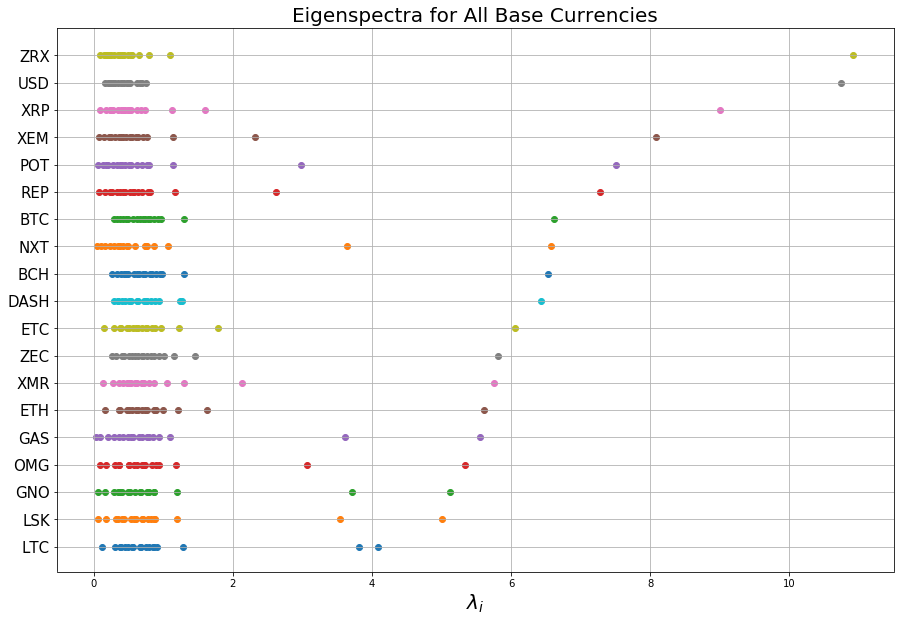

In [212]:
# Plot
fig, ax = plt.subplots(figsize=(15,10))
for jC in srt_all_currs:
    j = srt_all_currs.index(jC)
    y = [j for x in range(len(srt_eigs_mtx[j,:]))]
    ax.scatter(x=srt_eigs_mtx[j,:], y=y)

plt.yticks(np.arange(len(all_currs)))
ax.set_yticklabels(srt_all_currs, fontsize=15)
plt.xlabel("$\lambda_i$", fontsize=20)
plt.title("Eigenspectra for All Base Currencies", fontsize=20)
plt.grid()
plt.show()

Next we replicate _Figure 2_ in the Kwapień paper. This shows $\lambda_1$ (the max eigenvalue) for different baskets of currencies. I chose the baskets based on a visual inspection of the above chart. It appears that eigenvalues have "breaks" at BTC, ETC, and LTC. __Note:__ they chose their baskets based on liquidity and volume. We do not have that data so I chose to use $\lambda_1$ as the sorting parameter.

In [216]:
# Create Baskets
bsk1 = ['LTC']  # seems to be alone by iteself
bsk2 = ['LSK', 'GNO', 'OMG', 'GAS', 'ETH', 'XMR', 'ZEC', 'ETC']
bsk3 = ['DASH', 'BCH', 'NXT', 'BTC']
bsk4 = ['REP', 'POT', 'XEM', 'XRP', 'USD', 'ZRX']
bsk = [bsk1, bsk2, bsk3, bsk4]

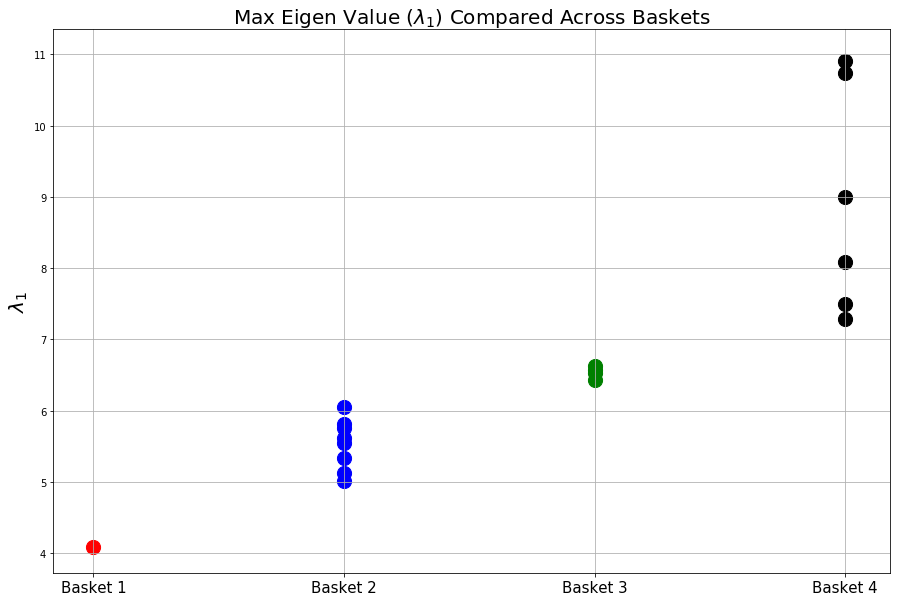

In [223]:
# Plot
colors = ['red', 'blue', 'green', 'black']
fig, ax = plt.subplots(figsize=(15,10))
for jB in bsk:  # loop over baskets (4)
    for jC in jB:
        j = srt_all_currs.index(jC)
        point = srt_eigs_mtx[j, srt_eigs_mtx.shape[1]-1]
        y = bsk.index(jB)
        ax.scatter(y=point, x=y, c=colors[bsk.index(jB)], s=200)

plt.xticks(np.arange(len(bsk)))
ax.set_xticklabels(['Basket 1', 'Basket 2','Basket 3', 'Basket 4'], fontsize=15)
plt.ylabel("$\lambda_1$", fontsize=20)
plt.title("Max Eigen Value ($\lambda_1$) Compared Across Baskets", fontsize=20)
plt.grid()
plt.show()

The Kwapień paper then also finds the residuals of the regression,

$$
G_X^B(t) = \beta G_Y^B(t) + \alpha + \epsilon_X^B(t), \quad i = 1,...,N-1
$$

in order to reduce the influence of USD and EUR on all the other base currency networks. I did it with LTC and BTC in our case. This means that $Y$ in our case is first LTC then BTC. We then perform the same analysis of eigenspectra but on the $\epsilon_X^B$ terms $\forall B$.

In Progress...

In [318]:
# Set two Regressor Currencies
reg_currs = ['LTC', 'BTC']
# TO DO

I next replicate _Figure 11_ in the Kwapień paper which shows the max eigen value, $\lambda_1$, over windowed time, to trace the importance of different base currencies. I, like the paper, split the analysis out by basket, I combine baskets 1 & 2 and then 3 & 4.

In [319]:
window = 24 * 20 * 6 # about six months rolling window
grp_bsk = [[bsk1 + bsk2], [bsk3 + bsk4]]  # grouped baskets

lam1_mtx = np.zeros((len(all_currs), exch_dat.shape[0]-1-window))  # bin for lambda 1s

# BTC First 
j = all_currs.index('BTC')
for jW in range(exch_dat.shape[0]-window-1):
    bott = jW
    top = jW + window
    exch_logrets = np.log(exch_dat.iloc[bott:top, :]) - np.log(exch_dat.iloc[bott:top, :].shift(1))
    exch_logrets = exch_logrets.iloc[1:,:]
    eigvals, eigvecs = np.linalg.eig(exch_logrets.corr())
    lam1_mtx[j,jW] = eigvals.max()

In [324]:
# Compute for each Base besides BTC
for jC in [x for x in all_currs if x not in 'BTC']:  # loop over all other base currencies
    j = all_currs.index(jC)
    temp = trans_base(exch_dat, 'BTC', jC)
    temp_logrets = np.log(temp) - np.log(temp.shift(1))
    temp_logrets = temp_logrets.iloc[1:,:]
    for jW in range(exch_dat.shape[0]-window-1):
        bott = jW
        top = jW + window
        eigvals, eigvecs = np.linalg.eig(temp_logrets.iloc[bott:top,:].corr())
        lam1_mtx[j,jW] = eigvals.max()

In [325]:
import matplotlib.dates as mdate
import datetime as dt

i = 0
dates = []
while i < exch_dat.shape[0]-window-1:
    dl = [int(x) for x in (exch_dat.index[i][:10]).split('-')]
    dates.append(dt.datetime(dl[0], dl[1], dl[2]))
    i += 1
x = list(dates)

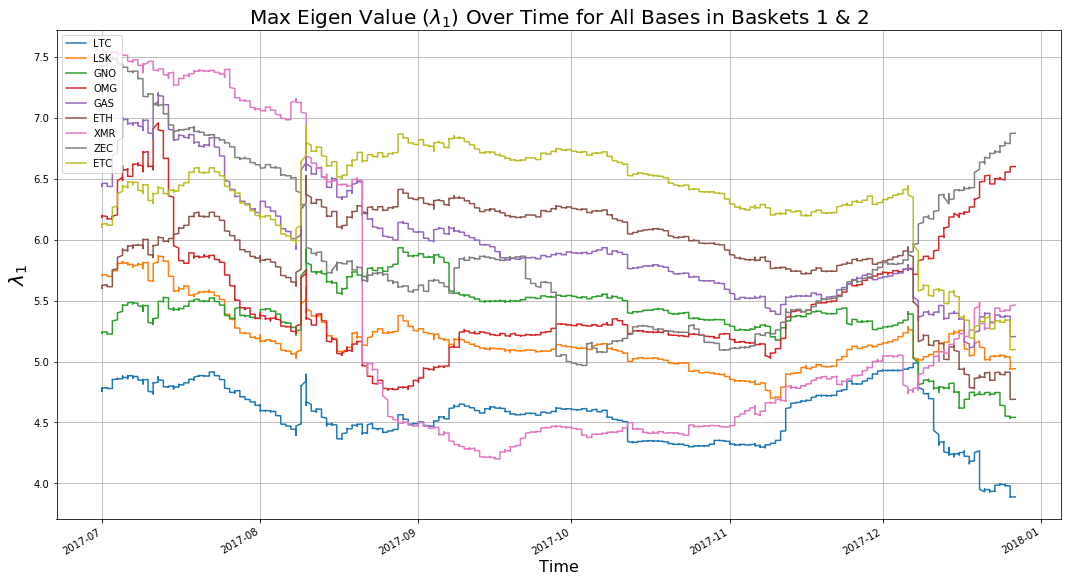

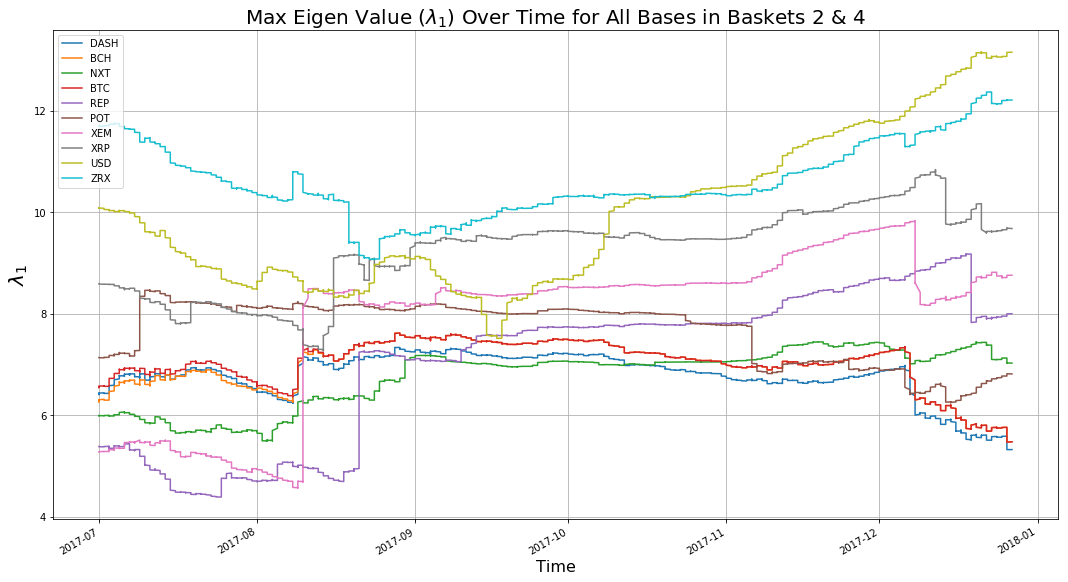

In [328]:
# Plot
fig, ax = plt.subplots(figsize=(18,10))
i = 0
jB = grp_bsk[i][0]
for jC in jB:
    j = all_currs.index(jC)
    ax.plot(x, lam1_mtx[j,:], label=all_currs[j])
plt.xlabel('Time', fontsize=16)
locator = mdate.MonthLocator()
plt.gca().xaxis.set_minor_locator(locator)
plt.gcf().autofmt_xdate()
plt.ylabel("$\lambda_1$", fontsize=20)
plt.title("Max Eigen Value ($\lambda_1$) Over Time for All Bases in Baskets 1 & 2", fontsize=20)
plt.grid()
plt.legend(loc='upper left')
plt.show()

fig, ax = plt.subplots(figsize=(18,10))
i = 1
jB = grp_bsk[i][0]
for jC in jB:
    j = all_currs.index(jC)
    ax.plot(x, lam1_mtx[j,:], label=all_currs[j])
plt.xlabel('Time', fontsize=16)
locator = mdate.MonthLocator()
plt.gca().xaxis.set_minor_locator(locator)
plt.gcf().autofmt_xdate()
plt.ylabel("$\lambda_1$", fontsize=20)
plt.title("Max Eigen Value ($\lambda_1$) Over Time for All Bases in Baskets 2 & 4", fontsize=20)
plt.grid()
plt.legend(loc='upper left')
plt.show()

### Cluster Structure
In the paper all they do is find some threshold $p_c$ and zero-out all entries in $C$ that are not greater than it. They do this for many $p_c$'s to find ones that give reasonable clusters based on geography or economic reasoning. This seems pretty weird to me and I think this would be a great time to add in spectral clustering. I will start with their method just for completeness though.
#### Thresholding $C$ Method (how paper does clustering)
The next set of plots are intended to resemble or convey the same information as _Figure 4_ in the Kwapień paper. They chose EUR, GBP, CHF, JPY, XAU, and GHS as the base currencies to look at graphs for. I choose BTC, USD, LTC, and ETH. I do not know how they got their graphs to look so neat but I almost sure they did it by hand, e.g. literally placed the nodes specifically. Thye also chose a specific $p_c$ such that the clusters looked stable, "we fix the threshold at p = p c for which the number of clusters is stable and close to a maximum", this is weird to me so I did a scale. Nonetheless are graphs show a similar story.

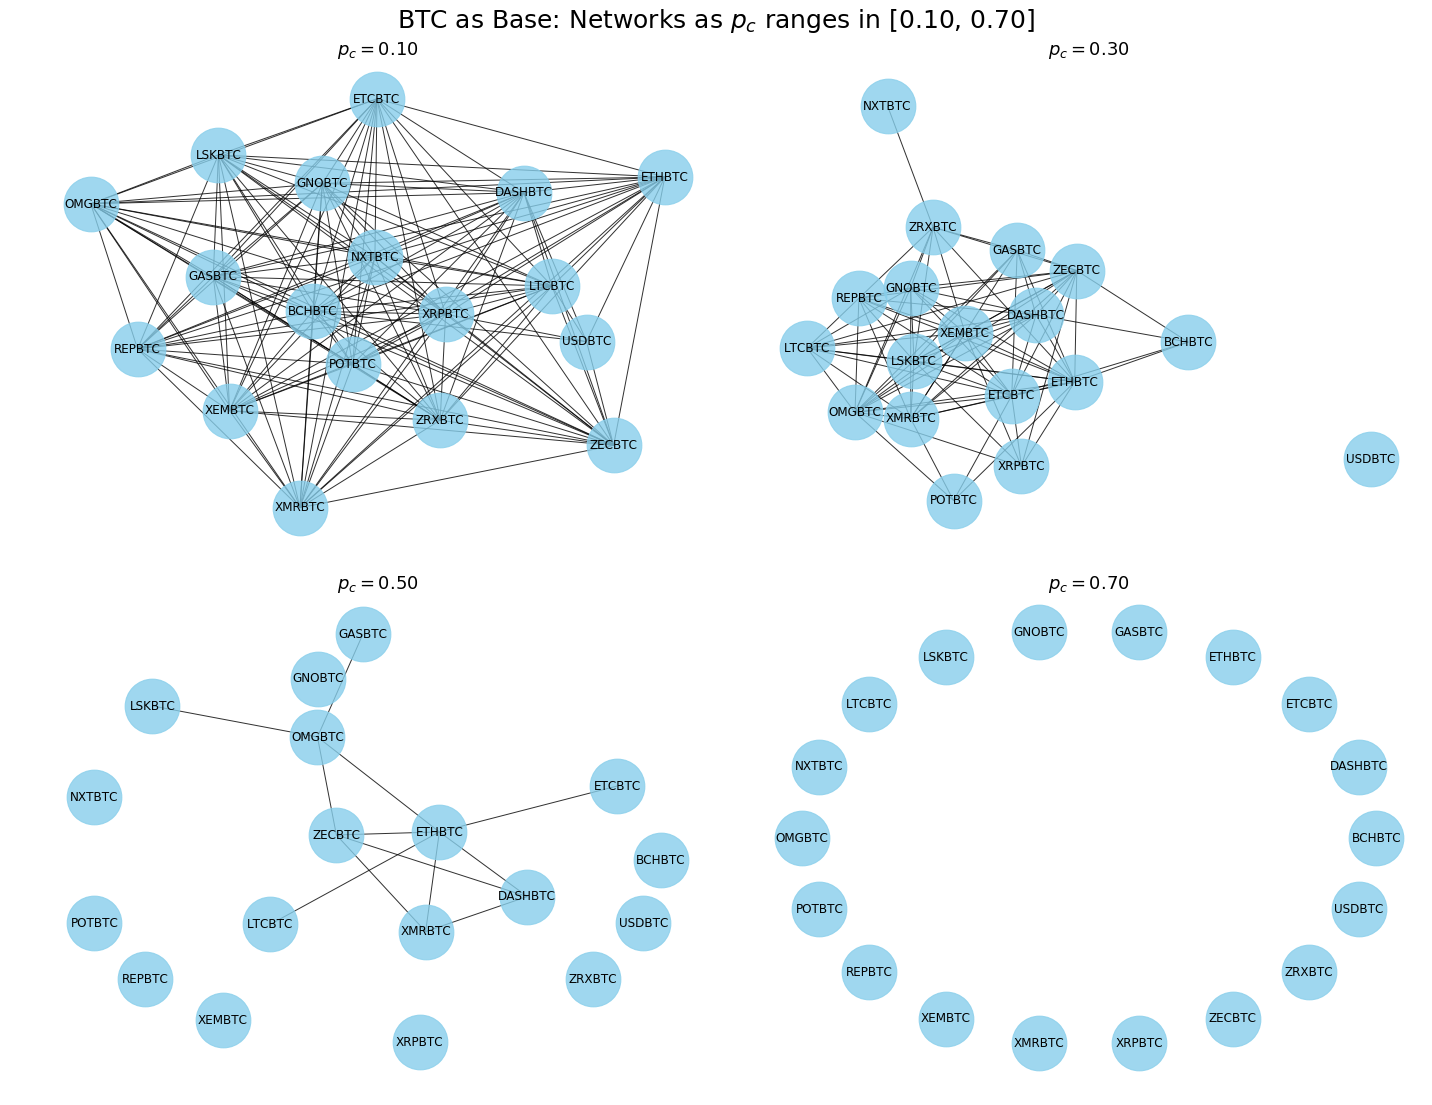

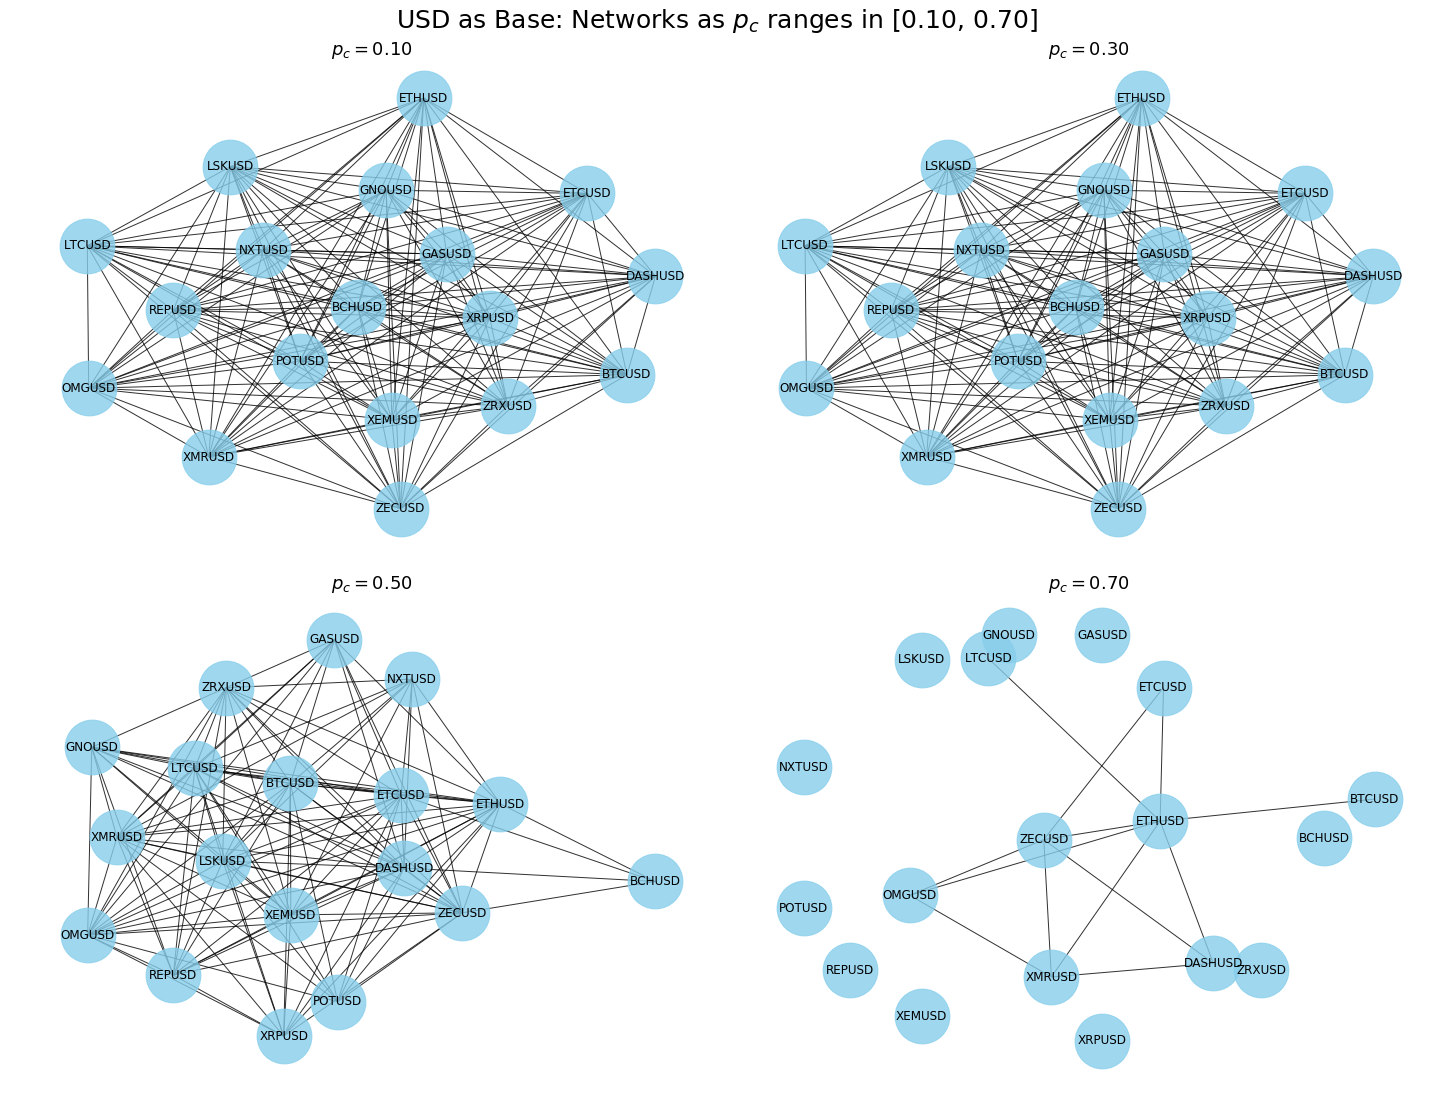

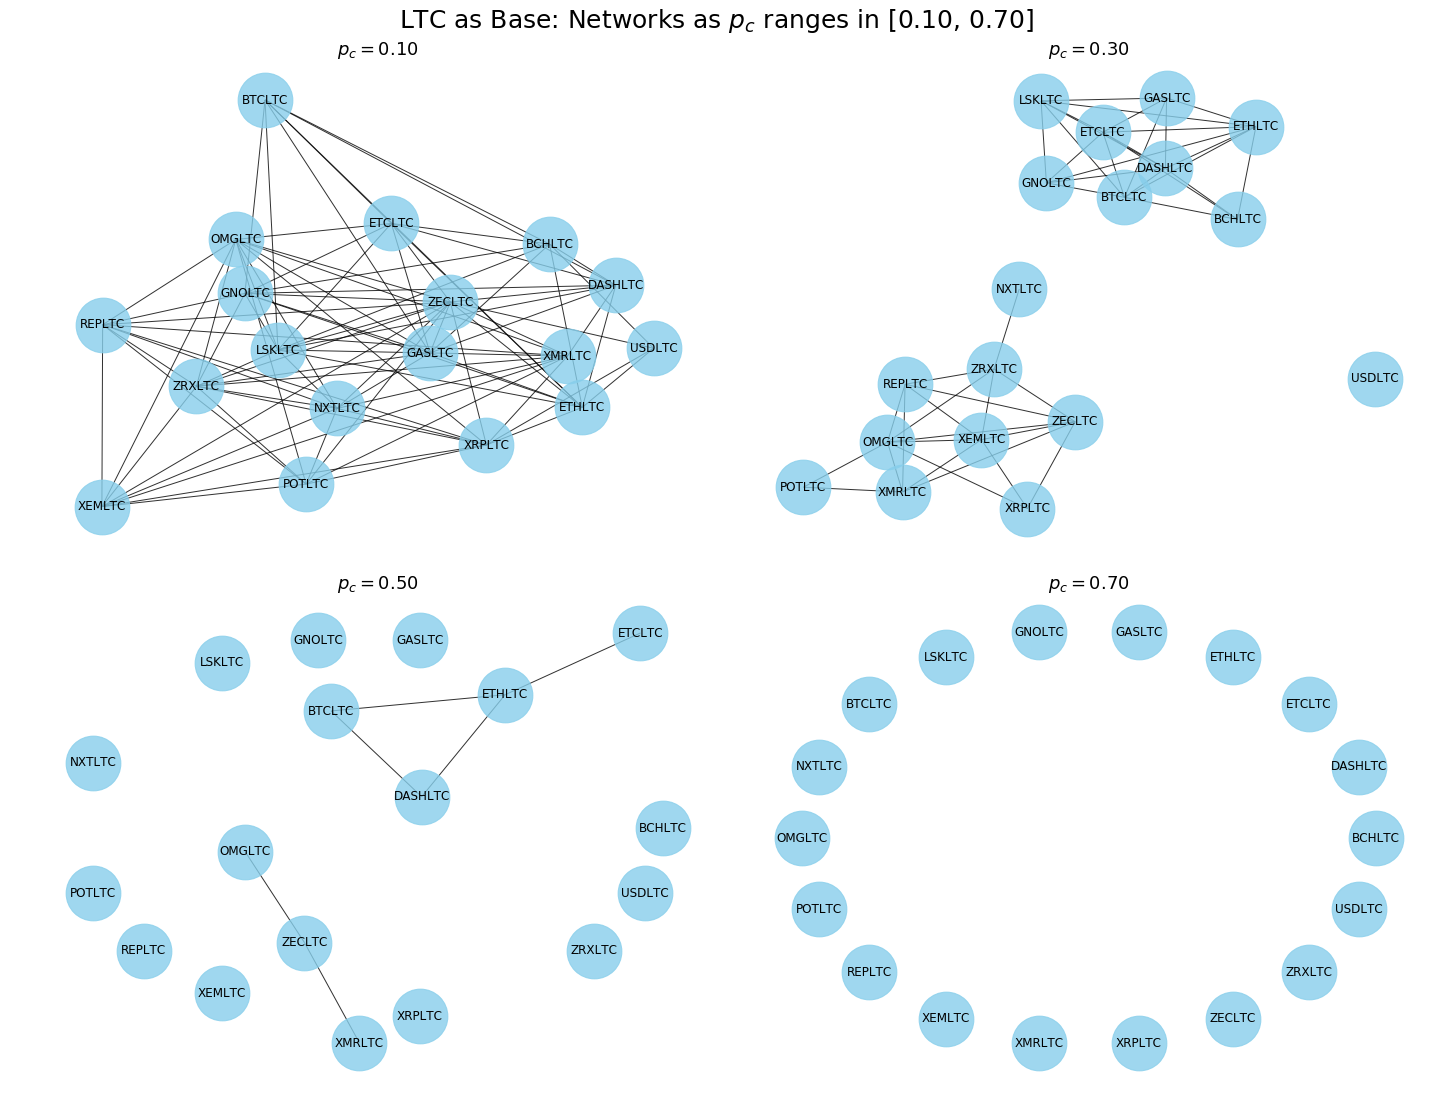

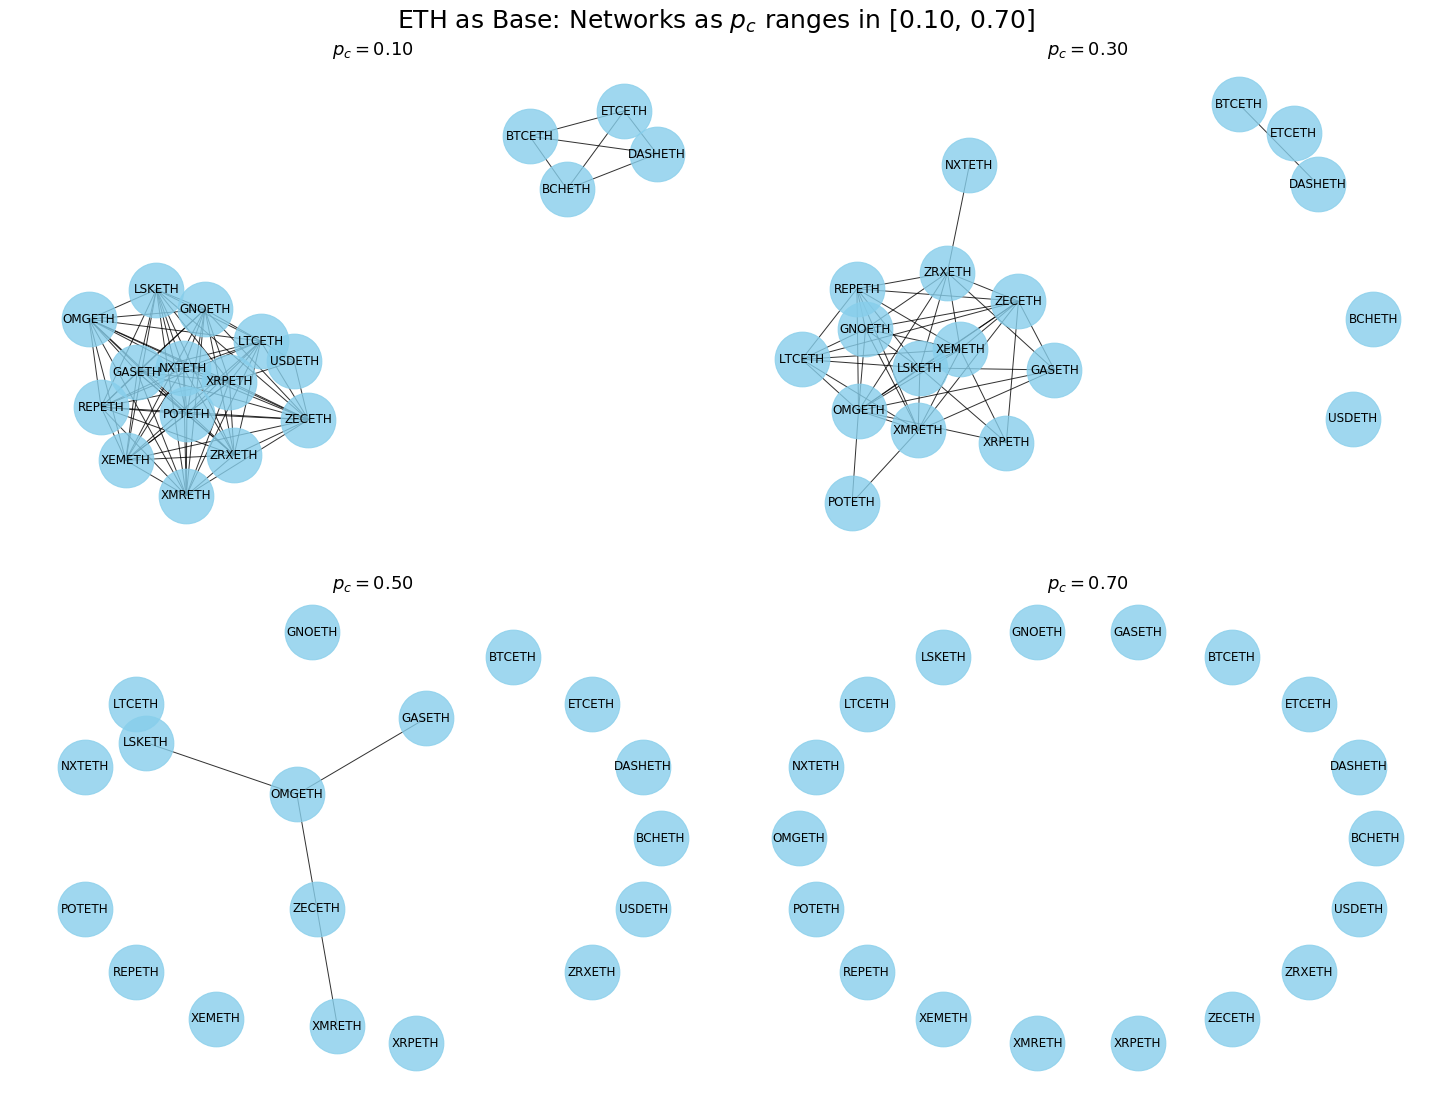

In [335]:
pcs = [1, 3, 5, 7]  # range parameter will take divided by 10

C_thresh = C.copy()  # copy it so we can alter it
labels = {}
for j in range(len(C_thresh.columns)):
    labels[j] = C_thresh.columns[j]

fig = plt.figure(figsize=(20, 15))
ttl = "BTC as Base: Networks as $p_c$ ranges in [0.10, 0.70]"
fig.suptitle(ttl, fontsize=25, y=1.02)
for plot_i, thresh_i in zip(range(len(pcs)), [x / 10 for x in pcs]):
    ax = fig.add_subplot(2, 2, plot_i+1)
    C_thresh = C.copy()  # copy it so we can alter it
    C_thresh[C_thresh < thresh_i] = 0
    C_thresh -= np.identity(C_thresh.shape[0])
    C_thresh = np.array(C_thresh)
    
    G = nx.Graph(C_thresh)
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, with_labels=False, node_size=3000, 
        node_color="skyblue", node_shape="o", 
        alpha=0.8, pos=pos)
    nx.draw_networkx_labels(G,pos,labels)
    ax.set_title('$p_c=$' + str(thresh_i) + "0", fontsize=18)
        
plt.tight_layout()
plt.show()

# Now for other Currencies
for new_base in ['USD', 'LTC', 'ETH']:
    temp = trans_base(exch_dat, 'BTC', new_base)

    temp = np.log(temp) - np.log(temp.shift(1))
    temp = temp.iloc[1:,:]
    C_thresh = temp.corr()
    labels = {}
    for j in range(len(C_thresh.columns)):
        labels[j] = C_thresh.columns[j]

    fig = plt.figure(figsize=(20, 15))
    ttl = new_base + " as Base: Networks as $p_c$ ranges in [0.10, 0.70]"
    fig.suptitle(ttl, fontsize=25, y=1.02)
    for plot_i, thresh_i in zip(range(len(pcs)), [x / 10 for x in pcs]):
        ax = fig.add_subplot(2, 2, plot_i+1)
        C_thresh = temp.corr()
        C_thresh[C_thresh < thresh_i] = 0
        C_thresh -= np.identity(C_thresh.shape[0])
        C_thresh = np.array(C_thresh)

        G = nx.Graph(C_thresh)
        pos = nx.kamada_kawai_layout(G)
        nx.draw(G, with_labels=False, node_size=3000, 
            node_color="skyblue", node_shape="o", 
            alpha=0.8, pos=pos)
        nx.draw_networkx_labels(G,pos,labels)
        ax.set_title('$p_c=$' + str(thresh_i) + "0", fontsize=18)

    plt.tight_layout()
    plt.show()

#### Spectral Clustering (what we improve with, paper does not do)
Here I simply use the correlation as the distance measure. We decided to go simply due to time constraints on the presentation. Similar to above I use BTC, USD, LTC, and ETH as my base currencies here.

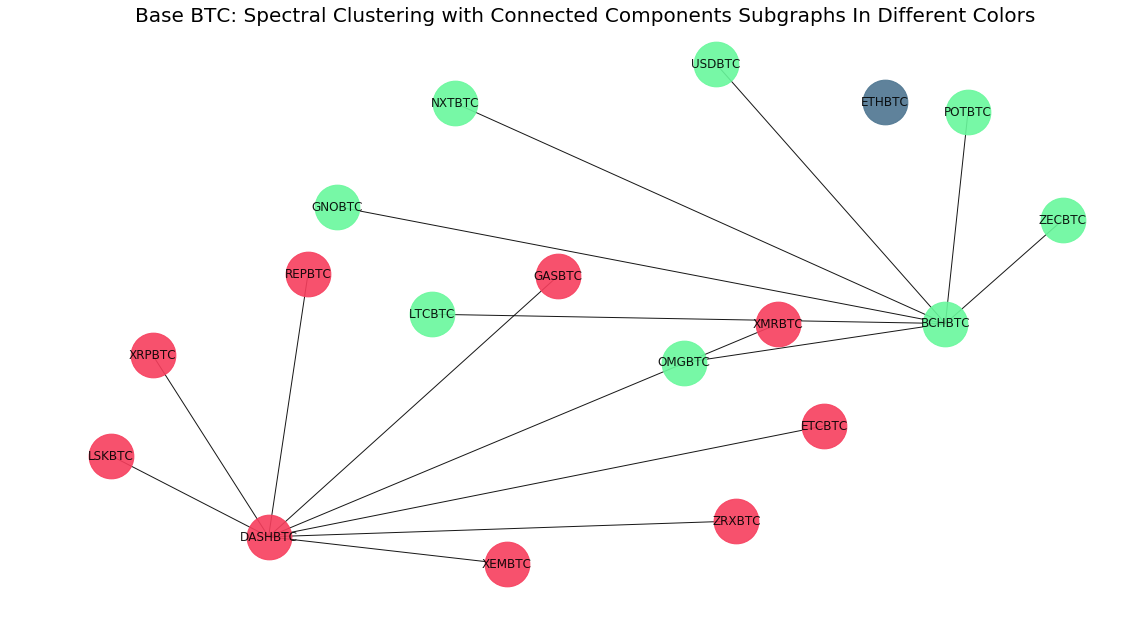

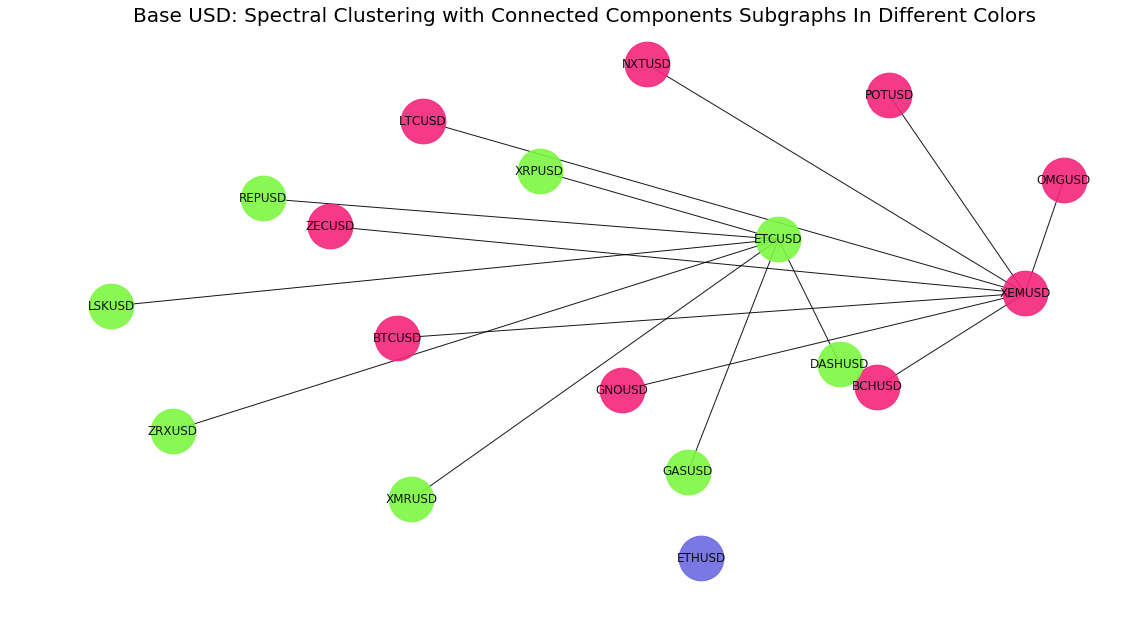

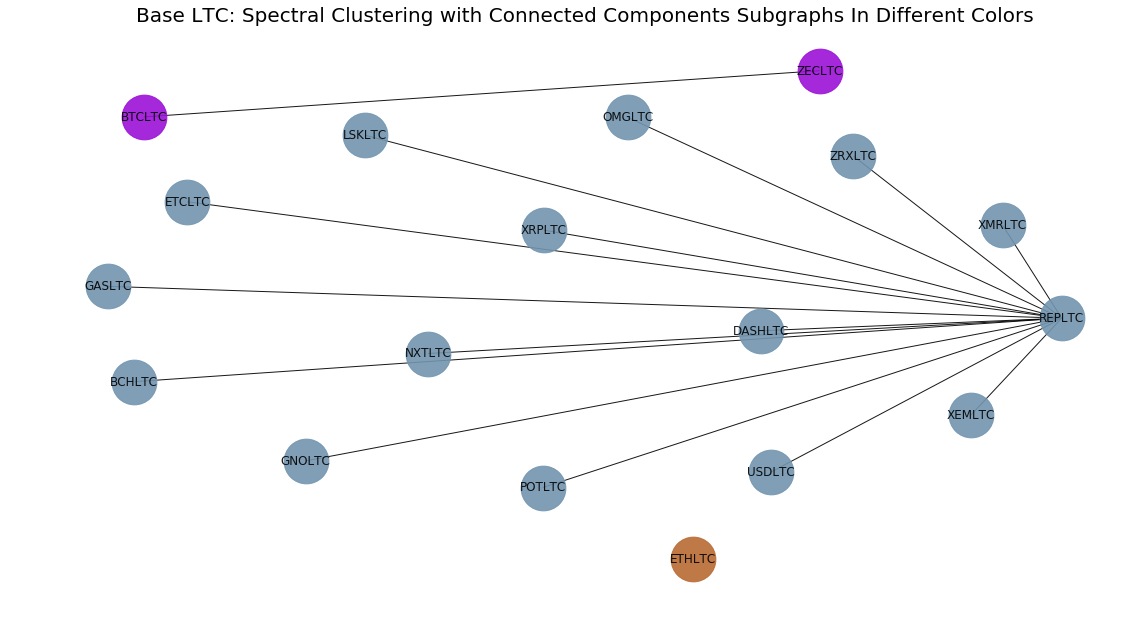

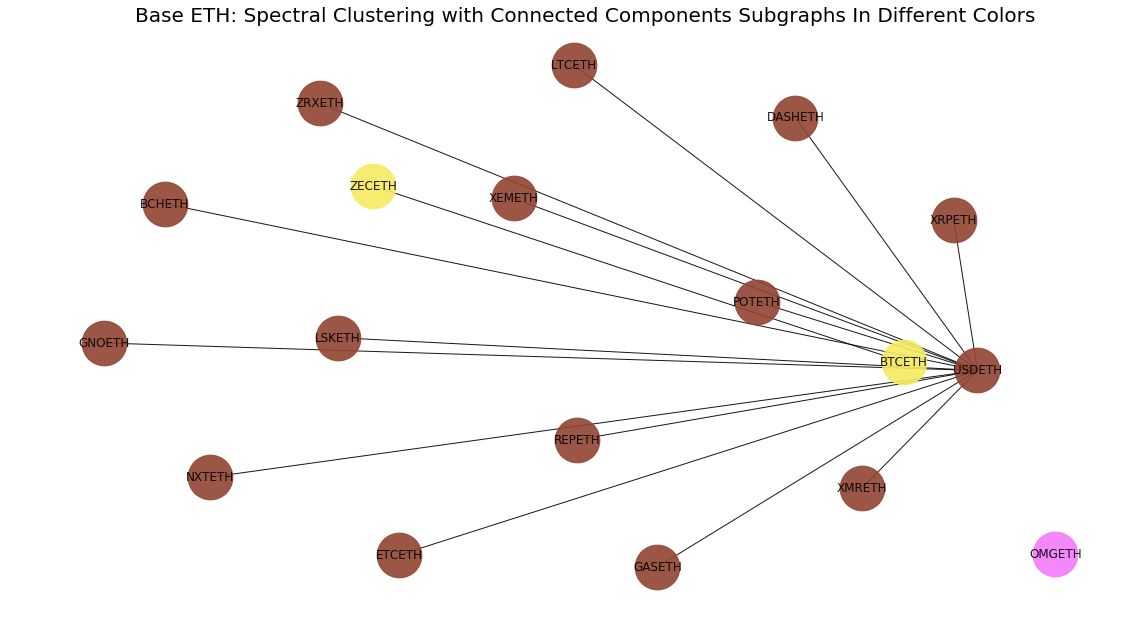

In [15]:
# First Just BTC (as it is already base)
D = np.sqrt(2 * (1 - C))
sc_mod = SpectralClustering(n_clusters=3, gamma=1.0, affinity='precomputed', assign_labels='kmeans')
clusters = sc_mod.fit_predict(D)

# Create Graph Dict From Clusters
M = dict()  # mapping dictionary
for jli in np.unique(clusters):
    ents = list(D.columns[clusters == jli])
    for jent in ents:
        if jent not in M:
            M[jent] = set([x for x in ents if x != jent])
        else:
            M[jent] |= set([x for x in ents if x != jent])

# Draw Graph (with subcomponents)
fig = plt.figure(figsize=(15, 8))
G = nx.Graph(M)
#nx.draw_networkx_nodes(M, pos)

C_group=nx.connected_component_subgraphs(G)
for g in C_group:
    c=[random.random()]*nx.number_of_nodes(g) # random color...
    pos = nx.kamada_kawai_layout(G)
    g = nx.minimum_spanning_tree(g)
    col = '#' + '%06X' % random.randint(0, 0xFFFFFF)
    nx.draw(g, pos, node_size=2000, edges=False,
         node_color=col, with_labels=True, alpha=.90)
plt.title("Base BTC: Spectral Clustering with Connected Components Subgraphs In Different Colors", 
         fontsize= 20)
plt.show();

# Now for other Currencies
for new_base in ['USD', 'LTC', 'ETH']:
    temp = trans_base(exch_dat, 'BTC', new_base)

    temp = np.log(temp) - np.log(temp.shift(1))
    temp = temp.iloc[1:,:]
    C_thresh = temp.corr()

    D = np.sqrt(2 * (1 - C_thresh))
    sc_mod = SpectralClustering(n_clusters=3, gamma=1.0, affinity='precomputed', assign_labels='kmeans')
    clusters = sc_mod.fit_predict(D)

    # Create Graph Dict From Clusters
    M = dict()  # mapping dictionary
    for jli in np.unique(clusters):
        ents = list(D.columns[clusters == jli])
        for jent in ents:
            if jent not in M:
                M[jent] = set([x for x in ents if x != jent])
            else:
                M[jent] |= set([x for x in ents if x != jent])

    # Draw Graph (with subcomponents)
    fig = plt.figure(figsize=(15, 8))
    G = nx.Graph(M)
    #nx.draw_networkx_nodes(M, pos)

    C_group=nx.connected_component_subgraphs(G)
    for g in C_group:
        c=[random.random()]*nx.number_of_nodes(g) # random color...
        pos = nx.kamada_kawai_layout(G)
        g = nx.minimum_spanning_tree(g)
        col = '#' + '%06X' % random.randint(0, 0xFFFFFF)
        nx.draw(g, pos, node_size=2000, edges=False,
             node_color=col, with_labels=True, alpha=.90)
    plt.title("Base " + new_base + ": Spectral Clustering with Connected Components Subgraphs In Different Colors", 
             fontsize= 20)
    plt.show();

### Minimal Spanning Tree (MST)
The below plots are intended to map to _Figure 8_ of the Kwapień paper. They use base GBP I use base BTC for no reason other than ease, which seems to be why they chose GBP.

They use MST in the paper for nothing other than making a graph easy to visualize and be interpretable. It doesn't give you antyhing besides telling you that for each node what is the closest node to it in distance. They define the distances as,

$$
d_{X,Y}^B = \sqrt{2(1 - C_{X,Y}^B)}.
$$


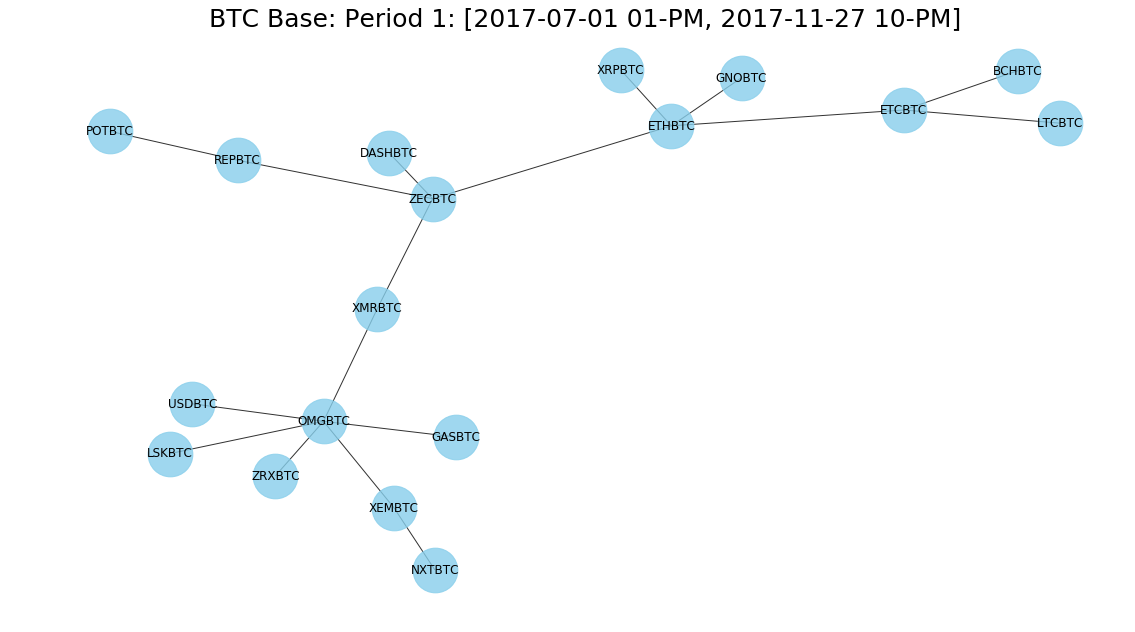

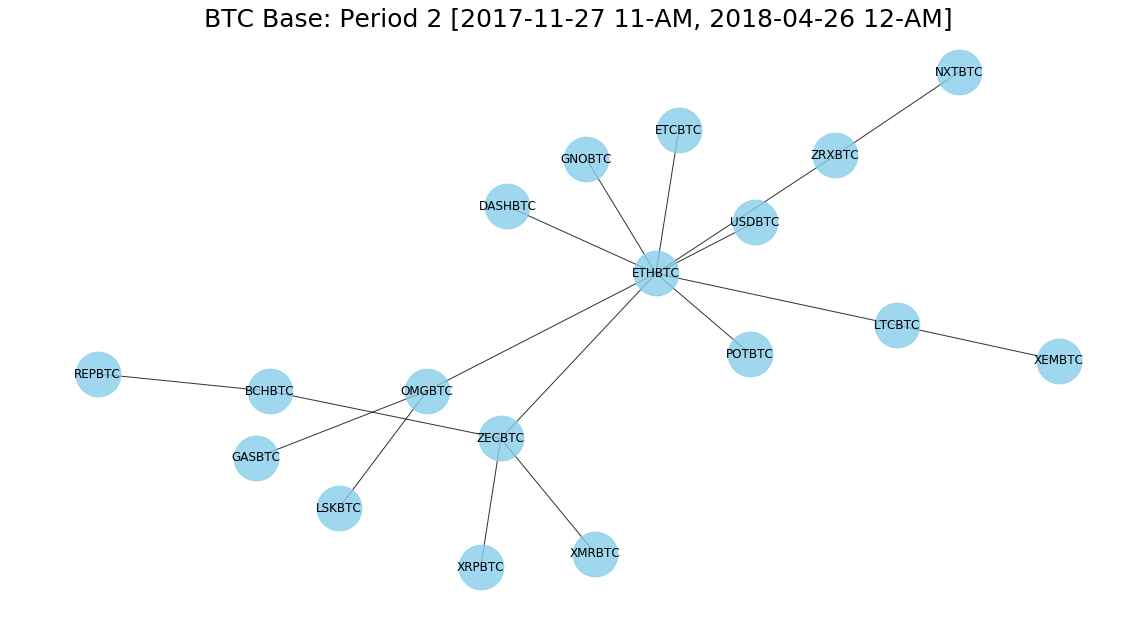

In [356]:
# Decide on two periods
start1 = '2017-07-01 01-PM'
end1   = '2017-11-27 10-PM'
start2 = '2017-11-27 11-AM'
end2   = '2018-04-26 12-AM'

# Period 1 Graph
bool1 = np.logical_and(exch_logrets.index >= start1, exch_logrets.index <= end1)
C_temp = exch_logrets[bool1].corr()  

D = np.sqrt(2 * (1 - C_temp))
MST = minimum_spanning_tree(D) # cst object. NOT a distance matrix.
MST_matrix = MST.toarray()

labels={}
for j in range(len(D.columns)):
    labels[j] = D.columns[j]
    
fig = plt.figure(figsize=(15, 8))
G = nx.Graph(MST_matrix)
pos = nx.fruchterman_reingold_layout(G)
nx.draw(G, with_labels=False, node_size=2000, 
        node_color="skyblue", node_shape="o", 
        alpha=0.8, pos=pos)
nx.draw_networkx_labels(G,pos,labels)
plt.title("BTC Base: Period 1: [" + str(start1) + ", " + str(end1) + "]" ,
         fontsize=25)
plt.show()

# Period 2 Graph
bool2 = np.logical_and(exch_logrets.index >= start2, exch_logrets.index <= end2)
C = exch_logrets[bool2].corr()  # only for x/USD
#C[C.isna()] = 0  # still some NAs in data

D = np.sqrt(2 * (1 - C))
MST = minimum_spanning_tree(D) # cst object. NOT a distance matrix.
MST_matrix = MST.toarray()

labels={}
for j in range(len(D.columns)):
    labels[j] = D.columns[j]
    
fig = plt.figure(figsize=(15, 8))
G = nx.Graph(MST_matrix)
pos = nx.fruchterman_reingold_layout(G)
nx.draw(G, with_labels=False, node_size=2000, 
        node_color="skyblue", node_shape="o", 
        alpha=0.8, pos=pos)
nx.draw_networkx_labels(G,pos,labels)
plt.title("BTC Base: Period 2 [" + str(start2) + ", " + str(end2) + "]" ,
         fontsize=25)
plt.show()